# Cleaning Melbourne sensor footfall data 
This script cleans the footfall data for Melbourne

#### Code initialisation

In [1]:
from os.path import samefile

import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
from datetime import date, datetime

# Add the path two directories up from the current notebook location
sys.path.append(os.path.abspath(os.path.join('..')))
# Now import the function from DataPrepFunctions.py
from DataPrepFunctions import check_and_prepare_data_directory

#### Import pedestrian count data

[ ] TODO: Need to upload the data to a permanent location and check that the download/extract (`check_and_prepare_data_directory`) function works.

**Activate the cell below if you don't already have all of the required input data and need to do a bulk download** 

The sensor data are in two files, 'old' and 'new'. See the [README](../../../README.md) for more information. We read them both and then consolidate them into one dataframe.

In [2]:
sensor_counts_old = pd.read_csv('../../Data/FootfallData/Pedestrian_Counting_System_Monthly_counts_per_hour_may_2009_to_14_dec_2022.csv')  # Origial file
sensor_counts_old

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...,...
4562225,4567697,"October 31, 2022 07:00:00 PM",2022,October,31,Monday,19,87,Errol St (West),185
4562226,4567698,"October 31, 2022 08:00:00 PM",2022,October,31,Monday,20,87,Errol St (West),108
4562227,4567699,"October 31, 2022 09:00:00 PM",2022,October,31,Monday,21,87,Errol St (West),58
4562228,4567700,"October 31, 2022 10:00:00 PM",2022,October,31,Monday,22,87,Errol St (West),18


In [9]:
sensor_counts_new  = pd.read_csv("../../Data/FootfallData/pedestrian-counting-system-monthly-counts-per-hour.csv")
sensor_counts_new


,ID,Location_ID,Sensing_Date,HourDay,Direction_1,Direction_2,Total_of_Directions,Sensor_Name,Location
0,421820211114,42,2021-11-14,18,25,24,49,UM1_T,"-37.80008566, 144.96386412"
1,461320231124,46,2023-11-24,13,88,101,189,Pel147_T,"-37.80240719, 144.9615673"
2,25420220305,25,2022-03-05,4,28,14,42,MCEC_T,"-37.82401776, 144.95604426"
3,30320240804,30,2024-08-04,3,141,203,344,Lon189_T,"-37.8112185, 144.96656806"
4,751120240108,75,2024-01-08,11,26,17,43,SprFli_T,"-37.81515276, 144.97467661"
...,...,...,...,...,...,...,...,...,...
1850388,631320230527,63,2023-05-27,13,346,706,1052,Bou231_T,"-37.81333081, 144.96675571"
1850389,501620240323,50,2024-03-23,16,261,296,557,Lyg309_T,"-37.79808192, 144.96721013"
1850390,201620240417,20,2024-04-17,16,251,227,478,LtB170_T,"-37.81172914, 144.9682466"
1850391,621520230905,62,2023-09-05,15,251,131,382,Lat224_T,"-37.80996494, 144.96216521"


In [10]:
sensor_locations = pd.read_csv('../../Data/FootfallData/melbourne_locations.csv')
sensor_locations

,sensor_id,Name,sensor_name,installation_date,status,note,direction_1,direction_2,Latitude,Longitude,location,Start,End,Values_per_sensor,Cluster_num_5clusters
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),NaN,NaN,-37.815734,144.965210,"(-37.81573422, 144.96521044)",2011.0,2015.0,30719.0,1
1,50,Faraday St-Lygon St (West),Lyg309_T,30/11/2017,A,NaN,South,North,-37.798082,144.967210,"(-37.79808191, 144.96721014)",2017.0,2022.0,46103.0,4
2,73,Bourke St - Spencer St (South),Bou655_T,02/10/2020,I,NaN,East,West,-37.816957,144.954154,"(-37.81695684, 144.95415373)",2020.0,2022.0,3648.0,0
3,66,State Library - New,QVN_T,06/04/2020,A,NaN,South,North,-37.810578,144.964443,"(-37.81057845, 144.96444294)",2020.0,2022.0,21912.0,1
4,59,Building 80 RMIT,RMIT_T,13/02/2019,A,NaN,South,North,-37.808256,144.963049,"(-37.80825648, 144.96304859)",2019.0,2022.0,32472.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,51,QVM-Franklin St (North),Fra118_T,30/11/2017,A,NaN,East,West,-37.808418,144.959063,"(-37.80841814, 144.95906317)",2017.0,2022.0,42553.0,4
87,63,231 Bourke St,Bou231_T,07/01/2020,A,NaN,East,West,-37.813331,144.966756,"(-37.81333081, 144.96675572)",2020.0,2022.0,22622.0,1
88,87,Errol St (West),Errol23_T,20/05/2022,A,NaN,South,North,-37.804549,144.949219,"(-37.80454949, 144.94921863)",2022.0,2022.0,2952.0,4
89,52,Elizabeth St-Lonsdale St (South),Eli263_T,31/07/2017,I,NaN,East,West,-37.812522,144.961940,"(-37.81252157, 144.9619401)",2017.0,2022.0,42238.0,1


#### Rename columns to all lowercase and standardise (to facilitate joining)

In [11]:
# Simply rename columns in the old file
sensor_counts_old.rename({'Date_Time': 'datetime', 'Year': 'year', 'Month':'month', 'Mdate': 'mdate', 
                      'Day': 'day', 'Time': 'time', 'Sensor_ID': 'sensor_id', 'Hourly_Counts': 'hourly_counts'}, 
                     axis = 1, inplace = True)
# Properly format datetime in old file
sensor_counts_old['datetime'] = pd.to_datetime(sensor_counts_old['datetime'], format = '%B %d, %Y %I:%M:%S %p')

# Need to do a little more manipulation for the new file (need to combine date and time columns and add two direction columns)
new_datetime = pd.to_datetime(sensor_counts_new['Sensing_Date']) + pd.to_timedelta(sensor_counts_new['HourDay'], unit='h')

 # Build new dataframe with columns that are consistent with the original
sensor_counts_new2 = pd.DataFrame({
    'ID' : sensor_counts_new.ID,
    'datetime': new_datetime, 
    'year': new_datetime.dt.year, 
    'month':new_datetime.dt.month_name(),
    'mdate': new_datetime.dt.day,
    'day': new_datetime.dt.day_name(),
    'time': new_datetime.dt.hour,
    'sensor_id': sensor_counts_new.Location_ID,
    'Sensor_Name': sensor_counts_new.Sensor_Name,
    'hourly_counts': sensor_counts_new.Direction_1 + sensor_counts_new.Direction_2
})

,ID,datetime,year,month,mdate,day,time,sensor_id,Sensor_Name,hourly_counts
0,421820211114,2021-11-14 18:00:00,2021,November,14,Sunday,18,42,UM1_T,49
1,461320231124,2023-11-24 13:00:00,2023,November,24,Friday,13,46,Pel147_T,189
2,25420220305,2022-03-05 04:00:00,2022,March,5,Saturday,4,25,MCEC_T,42
3,30320240804,2024-08-04 03:00:00,2024,August,4,Sunday,3,30,Lon189_T,344
4,751120240108,2024-01-08 11:00:00,2024,January,8,Monday,11,75,SprFli_T,43
...,...,...,...,...,...,...,...,...,...,...
1850388,631320230527,2023-05-27 13:00:00,2023,May,27,Saturday,13,63,Bou231_T,1052
1850389,501620240323,2024-03-23 16:00:00,2024,March,23,Saturday,16,50,Lyg309_T,557
1850390,201620240417,2024-04-17 16:00:00,2024,April,17,Wednesday,16,20,LtB170_T,478
1850391,621520230905,2023-09-05 15:00:00,2023,September,5,Tuesday,15,62,Lat224_T,382


#### Drop unneeded columns

In [12]:
sensor_counts_old.drop(['ID', 'Sensor_Name'], axis = 1, inplace = True)
sensor_counts_new2.drop(['ID', 'Sensor_Name'], axis = 1, inplace = True)
#sensor_locations.drop(['sensor_description', 'sensor_name', 'installation_date', 'status', 'note', 'direction_1',
#                      'direction_2'], axis = 1, inplace = True)

#### Merge hourly count data

Check the overlap as some dates are in both files

Only 10039 overlapping entries of 667254.


<Axes: >

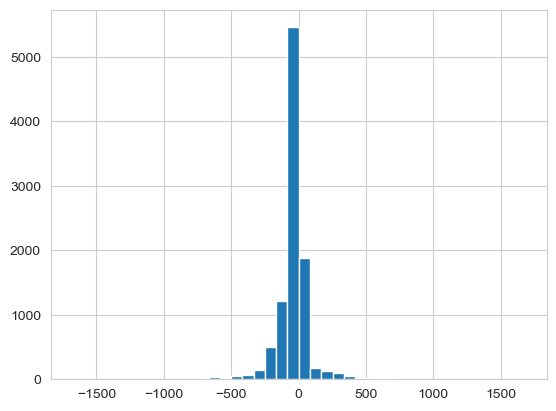

In [26]:
# Inner join on datetime and sensor to see which ones overlap
overlap = pd.merge(sensor_counts_old, sensor_counts_new2, on=['datetime', 'sensor_id'], suffixes=('_old', '_new'), how='inner')
# Check if the hourly_counts are the same for overlapping rows
overlap['counts_match'] = overlap['hourly_counts_old'] == overlap['hourly_counts_new']
overlap['diff'] = overlap.hourly_counts_old - overlap.hourly_counts_new
# Display overlapping entries and whether the counts match
#overlap.loc[overlap.counts_match == False, ['datetime', 'sensor_id', 'hourly_counts_old', 'hourly_counts_new', 'counts_match']]
print(f"Only {np.sum(np.array(overlap.counts_match)==False)} overlapping entries of {sum(overlap.counts_match)}.")
# Histogram of the difference in counts
overlap.loc[overlap.counts_match == False, 'diff'].hist(bins=40)

There is some overlap but it is insubstantial so just use the original data.

Now merge them, giving priority to the original data for any overlapping entries.

In [27]:
# Sanity checks before doing the merge
a = pd.concat([sensor_counts_old, sensor_counts_new2])
b = a.drop_duplicates(subset=['datetime', 'sensor_id'], keep='first')


assert len(a) == len(sensor_counts_old) + len(sensor_counts_new2), "New length doesn't equal old sums"
assert len(a) == len(b) + len(overlap), f"a: {len(a)}, b: {len(b)}, overlap: {len(overlap)}"

del a, b

sensor_counts = pd.concat([sensor_counts_old, sensor_counts_new2]).drop_duplicates(subset=['datetime', 'sensor_id'], keep='first')
sensor_counts

AssertionError: a: 6412623, b: 5723600, overlap: 677293

In [82]:
XXXX HERE WORK OUT WHY ABOVE DOESn'T WOK 

,datetime,year,month,mdate,day,time,sensor_id,hourly_counts
0,2019-11-01 17:00:00,2019,November,1,Friday,17,34,300
1,2019-11-01 17:00:00,2019,November,1,Friday,17,39,604
2,2019-11-01 17:00:00,2019,November,1,Friday,17,37,216
3,2019-11-01 17:00:00,2019,November,1,Friday,17,40,627
4,2019-11-01 17:00:00,2019,November,1,Friday,17,36,774
...,...,...,...,...,...,...,...,...
1848497,2023-07-27 10:00:00,2023,July,27,Thursday,10,47,927
1848499,2024-05-05 03:00:00,2024,May,5,Sunday,3,51,14
1848500,2023-07-08 21:00:00,2023,July,8,Saturday,21,123,28
1848501,2023-10-02 13:00:00,2023,October,2,Monday,13,44,107


#### Identify new sensors

Some new sensors have been introduced, mark them

In [ ]:
new_sensors = set(sensor_counts_new2.sensor_id.unique()) - set(sensor_counts_old.sensor_id.unique())
print(f"New sensors: {new_sensors}")


#### Join count data to sensor locations so that location and count info in same place

In [21]:
location_counts = pd.merge(sensor_locations, sensor_counts, on='sensor_id', how='inner')

#### It could be useful to drop sensors that do not have as many recorded countsfor now leaving them in, but may drop in the future

#### Order by datetime column

In [23]:
location_counts = location_counts.sort_values(by=['datetime'])
location_counts.reset_index(inplace = True, drop = True)

#### September, 2010 dates have problems:
All dates have a timestamp of 00:00, presume they are in order of hour of day, for each day there are only 23 hours worth of data
For now, in later stages just filter out 2010 data

In [24]:
location_counts = location_counts[location_counts['year']>2010]

### Clean and save data

In [25]:
# location_counts.drop(['Latitude', 'Longitude', 'location'], axis = 1, inplace =True)
# location_counts.rename({'day': 'weekday', 'mdate': 'day', 'time': 'hour'}, axis =1, inplace = True)

# Change month to integers 1-12
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June':6, 'July': 7, 'August': 8,
         'September': 9, 'October': 10, 'November': 11, 'December': 12}

location_counts.month = location_counts.month.map(months)

In [26]:
just_some_sensors = location_counts[location_counts['sensor_id'].isin([2,6,8,9,10,11,18])]
just_some_sensors.to_csv("../../Cleaned_data/SensorData/validsensors.csv",index=False)
location_counts.to_csv("../../Cleaned_data/SensorData/allsensors.csv",index=False)

In [11]:
# # Get data for just one sensor
# one_sensor =  location_counts[location_counts.sensor_id == 4]
# one_year = one_sensor[one_sensor.year==2010]
# # Set the datetime as the index
# one_sensor.set_index('datetime', inplace = True)
# duplicates = one_sensor[one_sensor.index.duplicated()]
# for day in duplicates.mdate.unique():
#     one_day = duplicates[duplicates.mdate == day]
#     print(day, len(one_day))

## Outlier removal

(_I think this is redundant now, performed before modelling_)

TODO: Remove following this redundant outlier removal code?

In [ ]:
def doubleMADsfromMedian(y,thresh=3.5):
    """Find outliers using the Median Average Distance.
    
    VALUE: return a list of true/false denoting whether the element in y is an outlier or not
    
    PARAMETERS:
      - y is a pandas Series, or something like that.
    
    warning: this function does not check for NAs
    nor does it address issues when 
    more than 50% of your data have identical values
    """
    # Calculate the upper and lower limits
    m = np.median(y) # The median
    abs_dev = np.abs(y - m) # The absolute difference between each y and the median
    # The upper and lower limits are the median of the difference
    # of each data point from the median of the data
    left_mad = np.median(abs_dev[y <= m]) # The left limit (median of lower half)
    right_mad = np.median(abs_dev[y >= m]) # The right limit (median of upper half)
    
    # Now create an array where each value has left_mad if it is in the lower half of the data,
    # or right_mad if it is in the upper half
    y_mad = left_mad * np.ones(len(y)) # Initially every value is 'left_mad'
    y_mad[y > m] = right_mad # Now larger values are right_mad

    # Calculate the z scores for each element
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    
    # Return boolean list showing whether each y is an outlier
    return modified_z_score > thresh

# Make a list of true/false for whether the footfall is an outlier
no_outliers = pd.DataFrame(doubleMADsfromMedian(original['InCount']))
no_outliers.columns = ['outlier'] # Rename the column to 'outlier'

# Join to the original footfall data to the list of outliers, then select a few useful columns
join = pd.concat([original, no_outliers], axis = 1)
join = pd.DataFrame(join, columns = ['Day_yr', 'outlier', 'InCount'])

# Choose just the outliers
outliers = join[join['outlier'] == True]
outliers_list = list(outliers['Day_yr']) # A list of the days that are outliers

# Now remove all outliers from the original data
df = original.loc[~original['Day_yr'].isin(outliers_list)]
df = df.reset_index(drop = True)

# Check that the lengths all make sense
assert(len(df) == len(original)-len(outliers_list))

print("I found {} outliers from {} days in total. Removing them leaves us with {} events".format(\
    len(outliers_list), len(join), len(df) ) )